In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
catalog = pd.read_csv('data/data_catalogue.csv')
data = pd.read_csv('data/data_arena_members.csv')

# Working with "catalog"

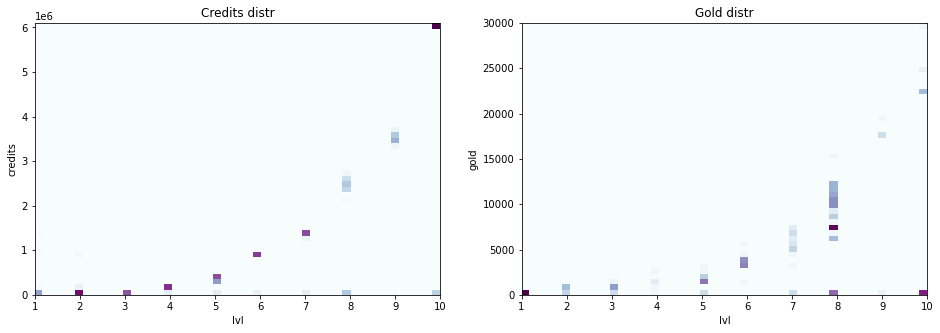

In [3]:
creds_catalog = catalog[catalog['item_price_gold'] == 0]
gold_catalog = catalog[catalog['item_price_credit'] == 0]

fig, axs = plt.subplots(1, 2, figsize=(16,5))

axs[0].hist2d(creds_catalog['item_level'], creds_catalog['item_price_credit'], bins=(50, 50), cmap=plt.cm.BuPu)
axs[0].set_title('Credits distr')
axs[0].set_xlabel('lvl')
axs[0].set_ylabel('credits')

axs[1].hist2d(gold_catalog['item_level'], gold_catalog['item_price_gold'], bins=(50, 50), cmap=plt.cm.BuPu)
axs[1].set_title('Gold distr')
axs[1].set_xlabel('lvl')
axs[1].set_ylabel('gold')

plt.show()

In [4]:
catalog.shape

(888, 6)

In [5]:
catalog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 6 columns):
item_cd              888 non-null int64
item_class           888 non-null object
item_price_credit    888 non-null int64
item_price_gold      888 non-null int64
item_level           888 non-null int64
crew_size            888 non-null int64
dtypes: int64(5), object(1)
memory usage: 41.8+ KB


## Check if there are any duplicate rows

In [6]:
# --> no duplicates
catalog.duplicated().sum()

0

## Check if there are any missing values

In [7]:
# --> no missing values
catalog.isnull().sum()

item_cd              0
item_class           0
item_price_credit    0
item_price_gold      0
item_level           0
crew_size            0
dtype: int64

## Have a closer look at some features

In [8]:
for feature in ['item_class', 'item_level']:
    catalog[feature] = pd.Categorical(catalog[feature])

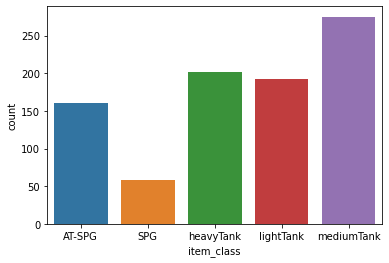

In [9]:
sns.countplot(catalog['item_class']);

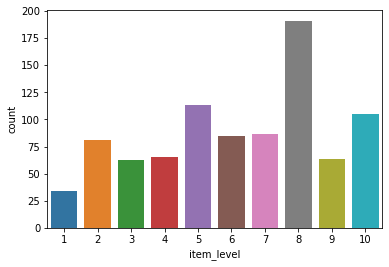

In [10]:
sns.countplot(catalog['item_level']);

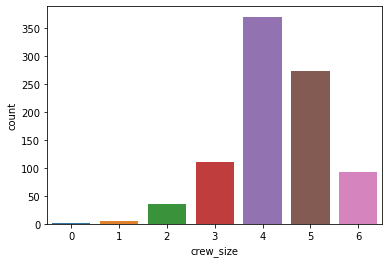

In [11]:
sns.countplot(catalog['crew_size']);

### There are a few tanks with crew_size = 0 or crew_size = 1:

> Level 1 or 10

> Cost nothing in both credits and gold (except for one)

> Mostly "lightTank"

In [12]:
catalog[(catalog['crew_size'] == 0) | (catalog['crew_size'] == 1)]

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
628,46145,lightTank,0,0,10,1
630,46353,heavyTank,0,0,10,1
762,57857,mediumTank,0,1,1,1
791,59921,SPG,0,0,1,0
880,65025,lightTank,0,0,1,1
884,65281,lightTank,0,0,1,1
886,65313,lightTank,0,0,1,0


### There are a few tanks that cost nothing in credits, as well as in gold:

> Mostly "lightTank" (23 out of 39)

> Mostly level = 1 (24 out of 39 - probably the first tanks every newcomer gets at the very beginning in WoT) and level = 10 (10 out of 39)

> crew_size varies

In [16]:
no_cost_tanks = catalog[(catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] == 0)]

In [17]:
no_cost_tanks['item_class'].value_counts()

lightTank     23
heavyTank      7
mediumTank     5
SPG            3
AT-SPG         1
Name: item_class, dtype: int64

In [18]:
no_cost_tanks['item_level'].value_counts()

1     24
10    10
5      2
7      1
3      1
2      1
9      0
8      0
6      0
4      0
Name: item_level, dtype: int64

# Working with "data" dataset

In [19]:
data.head()

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,mileage_meter,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp
0,2018-10-27,4yNy14y4yN12d42dT,c42c4aydT,2,0,0,0,2849,132,3,...,459,-3,27279,1084,15,20,11956,0,0,0
1,2018-10-27,4yNy14y4yN12d42dT,c2TaaayN4,1,500033550,0,0,63553,195,6,...,708,0,6282,68,15,10,9832,0,0,0
2,2018-10-27,4yNy14y4yN12d42dT,cyyd47dc4,2,500051107,67896661,0,17665,224,11,...,656,0,36102,3560,15,20,39190,0,0,1130
3,2018-10-27,4yNy14y4yN12d42dT,c2cdc441y,2,0,0,0,11537,381,8,...,1912,387,16317,1678,15,20,7217,0,0,0
4,2018-10-27,4yNy14y4yN12d42dT,cdT7cTT21,1,0,0,0,7937,198,5,...,507,0,11620,232,15,10,9532,0,0,0


## Check if there are any duplicates

In [20]:
# --> no duplicates
data.duplicated().sum()

0

## Check if there are any missing values

In [21]:
#  --> no null values
data.isnull().sum()

dt                          0
arena_id                    0
account_db_id               0
team_id                     0
clan_db_id                  0
prebattle_id                0
is_prebattle_creator        0
vehicle_type_cd             0
life_time_sec               0
shots                       0
hits                        0
he_hits                     0
pierced                     0
damage_dealt                0
damage_assisted_radio       0
damage_assisted_stun        0
damage_assisted_track       0
damage_received             0
shots_received              0
no_damage_shots_received    0
pierced_received            0
spotted                     0
damaged                     0
kills_made                  0
mileage_meter               0
remained_hp                 0
original_credits            0
original_xp                 0
premium_xp_factor           0
daily_xp_factor             0
battle_num                  0
damage_blocked_by_armor     0
booster_bonus_credits       0
booster_bo

In [22]:
data.describe()

,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,hits,he_hits,pierced,...,mileage_meter,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp
count,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,...,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06
mean,1.500012e+00,2.843463e+08,7.294238e+06,7.078356e-02,2.385905e+04,2.976262e+02,7.737261e+00,5.338601e+00,3.319876e-01,3.642870e+00,...,1.172209e+03,1.898441e+02,3.101604e+04,1.051142e+03,1.499911e+01,1.359025e+01,2.330818e+04,4.413510e+02,2.001733e+03,1.087805e+02
std,5.000002e-01,2.476774e+08,2.682621e+07,2.564630e-01,2.240161e+04,1.348282e+02,5.083631e+00,4.033531e+00,1.314018e+00,3.004760e+00,...,7.146287e+02,3.944958e+02,2.388009e+04,1.048554e+03,1.153523e-01,7.431458e+00,1.681642e+04,7.220232e+02,7.045504e+03,2.797012e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-1.300000e+01,-1.037000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.501000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.377000e+03,2.010000e+02,4.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,...,6.920000e+02,0.000000e+00,1.472100e+04,3.300000e+02,1.500000e+01,1.000000e+01,1.052400e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,5.000197e+08,0.000000e+00,0.000000e+00,1.334500e+04,2.870000e+02,7.000000e+00,5.000000e+00,0.000000e+00,3.000000e+00,...,1.027000e+03,0.000000e+00,2.421500e+04,6.900000e+02,1.500000e+01,1.000000e+01,1.931600e+04,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000e+00,5.000720e+08,0.000000e+00,0.000000e+00,5.019300e+04,3.740000e+02,1.000000e+01,7.000000e+00,0.000000e+00,5.000000e+00,...,1.507000e+03,1.180000e+02,3.972500e+04,1.418000e+03,1.500000e+01,2.000000e+01,3.192900e+04,6.400000e+02,0.000000e+00,0.000000e+00
max,2.000000e+00,5.001649e+08,2.687535e+08,1.000000e+00,6.528100e+04,9.000000e+02,6.300000e+01,5.100000e+01,2.700000e+01,4.000000e+01,...,1.491800e+04,3.000000e+03,3.055860e+05,1.341000e+04,1.500000e+01,4.000000e+01,2.210440e+05,1.665000e+04,1.577200e+05,3.274000e+03


## Have a closer look at some features

In [23]:
data[data['remained_hp'] < 0].shape

(116746, 34)